In [1]:
from heapq import merge

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import ecdfs
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os 
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px


# Load Data

In [2]:
DATA_PATH = "../data/processed/2020/survey_results_public_processed.pkl"

In [3]:
raw_df = pd.read_pickle(DATA_PATH)
raw_df

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,"[ASP.NET, ASP.NET Core]",Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,[],Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,[],Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,[],Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,[Ruby on Rails],Just as welcome now as I felt last year,NaN,15,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64456,64858,NaN,Yes,NaN,16,NaN,NaN,NaN,United States,NaN,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,[],NaN,NaN,10,0
64457,64867,NaN,Yes,NaN,NaN,NaN,NaN,NaN,Morocco,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
64458,64898,NaN,Yes,NaN,NaN,NaN,NaN,NaN,Viet Nam,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
64459,64925,NaN,Yes,NaN,NaN,NaN,NaN,NaN,Poland,NaN,...,NaN,NaN,NaN,NaN,Angular;Angular.js;React.js,[],NaN,NaN,NaN,NaN


In [4]:
data = raw_df.copy()

# Skills Analysis

In [5]:
FEATS = [
    'LanguageWorkedWith',
     'DatabaseWorkedWith',
     'PlatformWorkedWith',
     'WebframeWorkedWith',
     'MiscTechWorkedWith',
] 

LABEL = ['DevType']

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder

In [7]:
# Drop rows where DevType is null. 
# These rows can't be used for training and testing
# as DevType is our label 

print(f"Before deleting null values: {data.shape}")
data.dropna(subset='DevType', inplace=True)
print(f"After deleting null values: {data.shape}")


Before deleting null values: (64461, 61)
After deleting null values: (64461, 61)


In [10]:
data[FEATS + LABEL].sample().iloc[0]

LanguageWorkedWith    [Bash/Shell/PowerShell, C++, Java, JavaScript,...
DatabaseWorkedWith                          [Elasticsearch, PostgreSQL]
PlatformWorkedWith    [Arduino, AWS, Docker, Google Cloud Platform, ...
WebframeWorkedWith                                      [Flask, Spring]
MiscTechWorkedWith    [Apache Spark, Node.js, Pandas, Teraform, Unit...
DevType                                                              []
Name: 53017, dtype: object

In [18]:
# # Encoding Skills Set

encoded_feats = {}
binarizer = MultiLabelBinarizer()

for col in FEATS + LABEL:
    print(f".. {col}")
    binarized_df = pd.DataFrame(binarizer.fit_transform(data[col]),  
                 columns=binarizer.classes_, 
                 index=data[col].index)

    encoded_feats[col] = binarized_df



.. LanguageWorkedWith
.. DatabaseWorkedWith
.. PlatformWorkedWith
.. WebframeWorkedWith
.. MiscTechWorkedWith
.. DevType


In [20]:
encoded_feats  = pd.concat(encoded_feats, axis=1)
encoded_feats

LanguageWorkedWith                                                   \
                Assembly Bash/Shell/PowerShell  C C# C++ Dart Go HTML/CSS   
0                      0                     0  0  1   0    0  0        1   
1                      0                     0  0  0   0    0  0        0   
2                      0                     0  0  0   0    0  0        0   
3                      0                     0  0  0   0    0  0        0   
4                      0                     0  0  0   0    0  0        1   
...                  ...                   ... .. ..  ..  ... ..      ...   
64456                  0                     0  0  0   0    0  0        0   
64457                  1                     1  1  1   1    1  1        1   
64458                  0                     0  0  0   0    0  0        0   
64459                  0                     0  0  0   0    0  0        1   
64460                  0                     0  0  1   0    0  0        1   

                    ...           DevType                          \
      Haskell Java  ... Developer, mobile Educator Engineer, data   
0           0    0  ...                 0        0              0   
1           0    0  ...                 1        0              0   
2           0    0  ...                 0        0              0   
3           0    0  ...                 0        0              0   
4           0    0  ...                 0        0              0   
...       ...  ...  ...               ...      ...            ...   
64456       0    0  ...                 0        0              0   
64457       1    1  ...                 0        0              0   
64458       0    0  ...                 0        0              0   
64459       0    0  ...                 0        0              0   
64460       0    1  ...                 0        0              0   

                                                      \
      Engineer, site reliability Engineering manager   
0                              0                   0   
1                              0                   0   
2                              0                   0   
3                              0                   0   
4                              0                   0   
...                          ...                 ...   
64456                          0                   0   
64457                          0                   0   
64458                          0                   0   
64459                          0                   0   
64460                          0                   0   

                                                                 \
      Marketing or sales professional Product manager Scientist   
0                                   0               0         0   
1                                   0               0         0   
2                                   0               0         0   
3                                   0               0         0   
4                                   0               0         0   
...                               ...             ...       ...   
64456                               0               0         0   
64457                               0               0         0   
64458                               0               0         0   
64459                               0               0         0   
64460                               0               0         0   

                                                
      Senior executive/VP System administrator  
0                       0                    0  
1                       0                    0  
2                       0                    0  
3                       0                    0  
4                       0                    0  
...                   ...                  ...  
64456                   1                    0  
64457                   0                    0  
64458          

In [22]:
feats_columns = FEATS 
label_column = LABEL


# Job Analysis

In [20]:
job_freq = encoded_label.apply(lambda x : x.value_counts()).T
job_freq.columns = ['Zeros', 'Ones']
job_freq

,Zeros,Ones
Academic researcher,58207,1238
Blockchain,59210,235
Cloud infrastructure engineer,58811,634
Data engineer,58327,1118
Data or business analyst,58922,523
Data scientist or machine learning specialist,58421,1024
Database administrator,59274,171
Designer,59263,182
DevOps specialist,58426,1019
Developer Advocate,59340,105


In [21]:
job_freq = job_freq.sort_values(by='Ones', ascending=False)
job_freq

,Zeros,Ones
"Developer, full-stack",41185,18260
"Developer, back-end",49517,9928
Student,54343,5102
"Developer, front-end",56096,3349
"Developer, desktop or enterprise applications",56952,2493
Other (please specify):,56987,2458
"Developer, mobile",57424,2021
"Developer, embedded applications or devices",57822,1623
Engineering manager,58170,1275
Academic researcher,58207,1238


In [22]:
job_freq[0:10].index.values

array(['Developer, full-stack', 'Developer, back-end', 'Student',
       'Developer, front-end',
       'Developer, desktop or enterprise applications',
       'Other (please specify):', 'Developer, mobile',
       'Developer, embedded applications or devices',
       'Engineering manager', 'Academic researcher'], dtype=object)

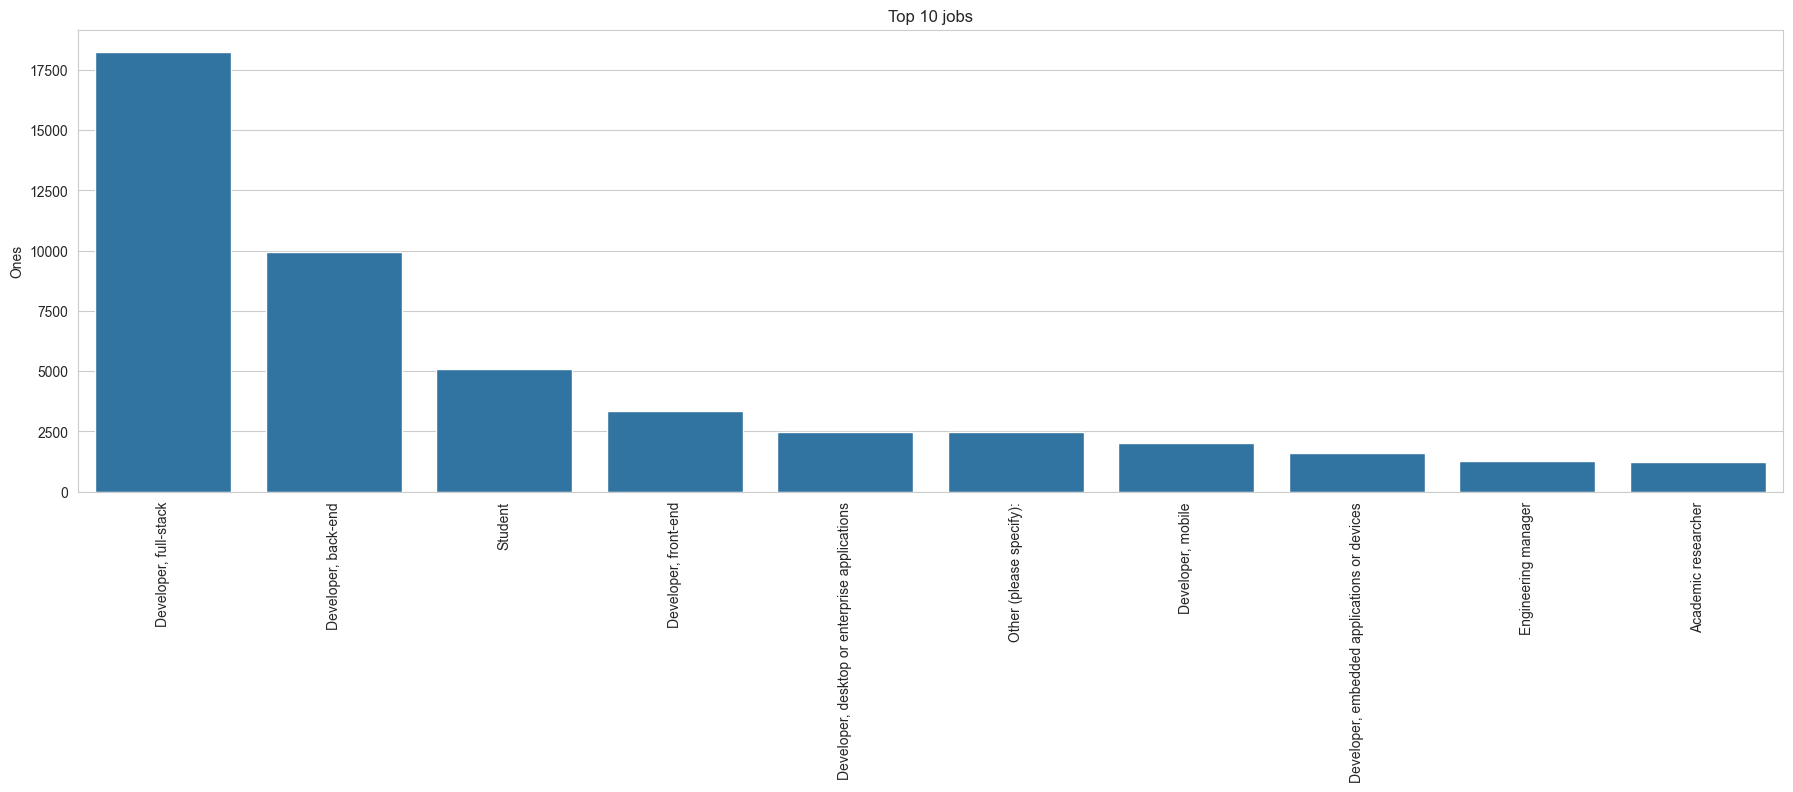

In [23]:
plt.figure(figsize=(22,6))
sns.barplot(data=job_freq[0:10], x=job_freq[0:10].index.values, y=job_freq[0:10]['Ones'])
plt.xticks(rotation=90)
plt.title("Top 10 jobs")
plt.show()

Number of jobs in the dataset: (34, 2)


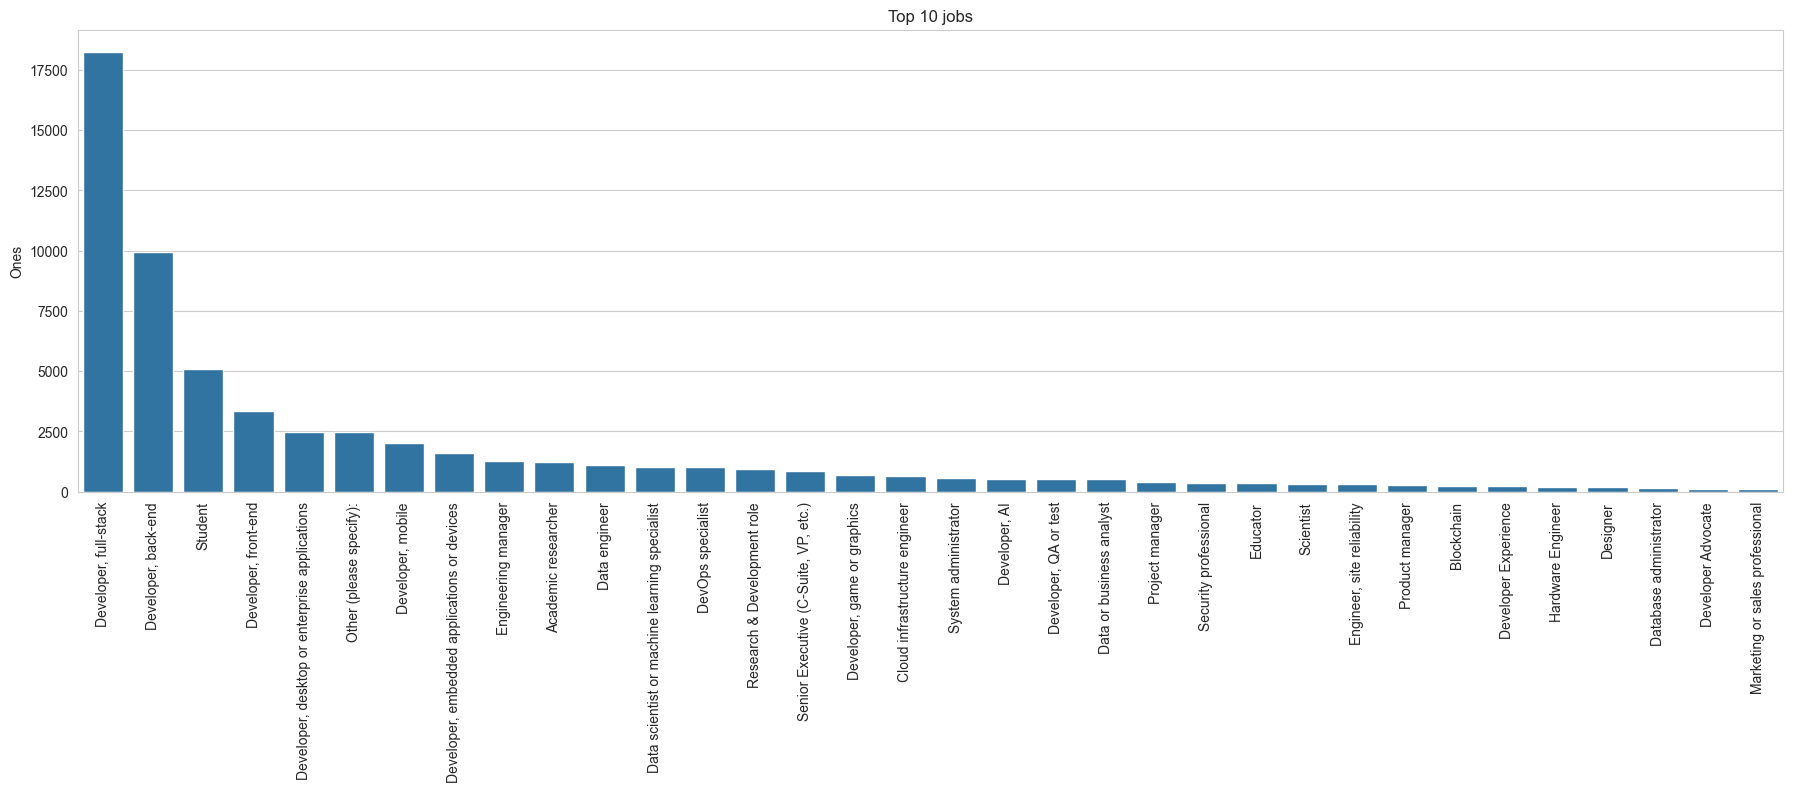

In [24]:
print(f"Number of jobs in the dataset: {job_freq.shape}")

plt.figure(figsize=(22,6))
sns.barplot(data=job_freq, x=job_freq.index.values, y=job_freq['Ones'])
plt.xticks(rotation=90)
plt.title("Top 10 jobs")
plt.show()

## The difference between Data Scientist & Developer, AI

In [25]:
dev_ai = encoded_df[encoded_df['Developer, AI'] == 1]

In [26]:
skills_freq = dev_ai[feats_columns].apply(lambda x: x.value_counts()).T
skills_freq.columns = ['Zeros', 'Ones']
skills_freq

,Zeros,Ones
Ada,533,10
Apex,533,10
Assembly,501,42
Bash/Shell (all shells),356,187
C,428,115
...,...,...
Vite,473,70
Webpack,496,47
Yarn,479,64
npm,369,174


In [27]:
skills_freq = skills_freq.sort_values(by='Ones', ascending=False)

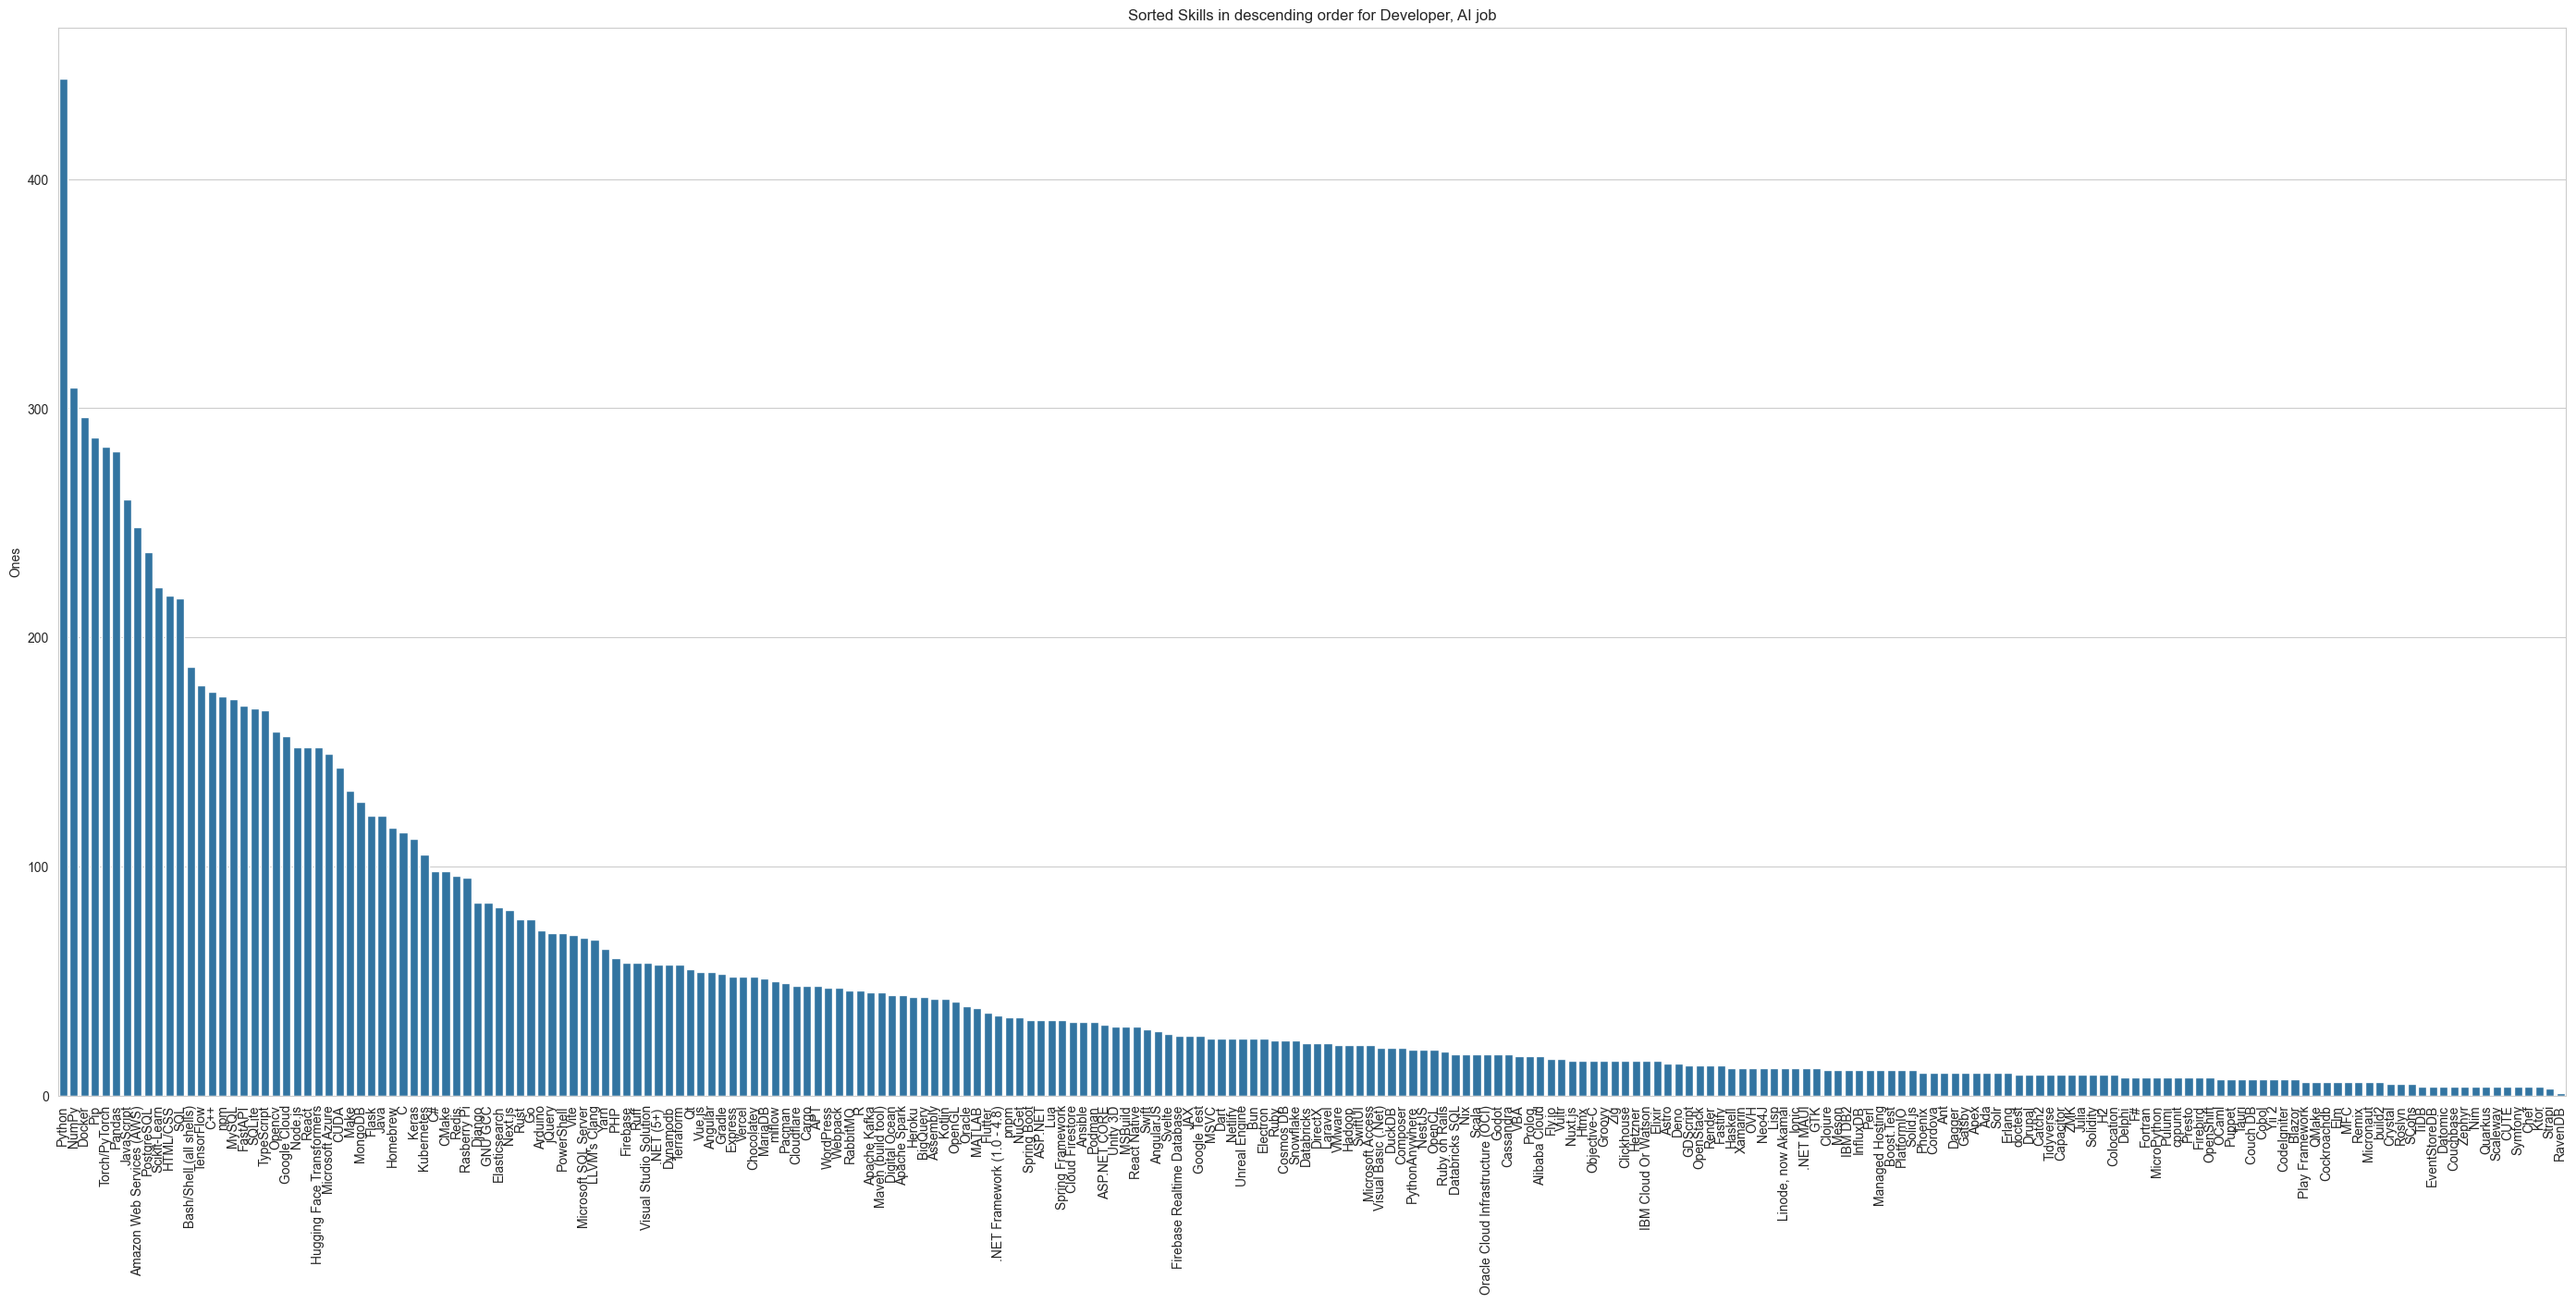

In [28]:
plt.figure(figsize=(35,15))
sns.barplot(data=skills_freq, x=skills_freq.index.values, y=skills_freq['Ones'])
plt.xticks(rotation=90)
plt.title("Sorted Skills in descending order for Developer, AI job")
plt.show()

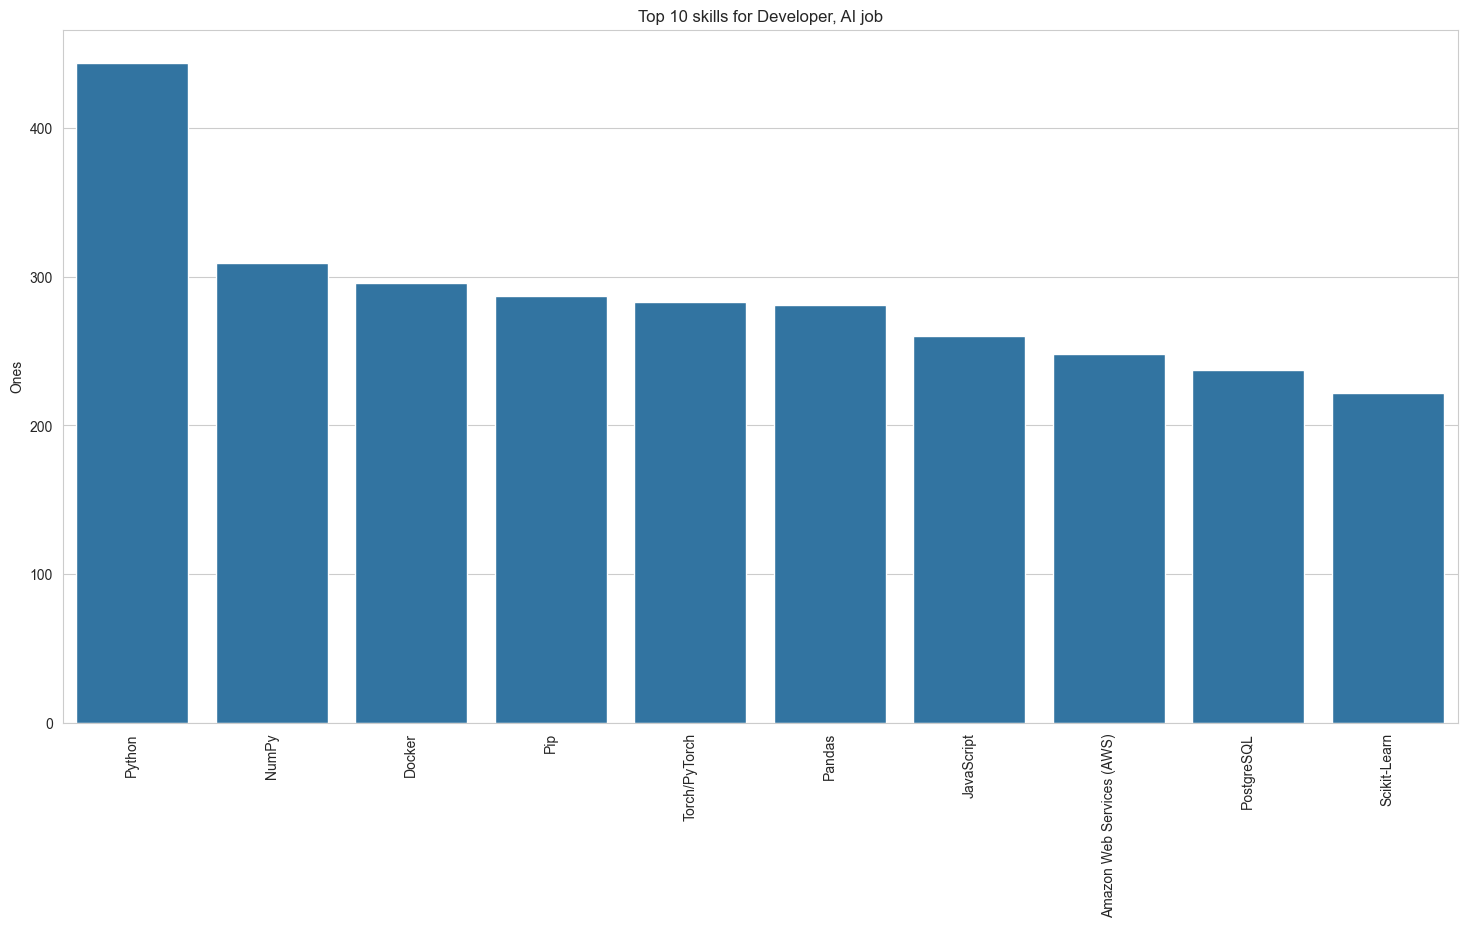

In [29]:
plt.figure(figsize=(18, 9))
sns.barplot(data=skills_freq[0:10], x=skills_freq[0:10].index.values, y=skills_freq[0:10]['Ones'])
plt.xticks(rotation=90)
plt.title("Top 10 skills for Developer, AI job")
plt.show()

In [30]:
data_scientist = encoded_df[encoded_df['Data scientist or machine learning specialist'] == 1]
data_scientist

,Ada,Apex,Assembly,Bash/Shell (all shells),C,C#,C++,Clojure,Cobol,Crystal,...,Marketing or sales professional,Other (please specify):,Product manager,Project manager,Research & Development role,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",Student,System administrator
37,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72,0,0,1,1,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64886,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65069,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65121,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65209,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
skills_freq = data_scientist[feats_columns].apply(lambda x: x.value_counts()).T
skills_freq.columns = ['Zeros', 'Ones']
skills_freq

,Zeros,Ones
Ada,1014.0,10.0
Apex,1016.0,8.0
Assembly,989.0,35.0
Bash/Shell (all shells),675.0,349.0
C,859.0,165.0
...,...,...
Vite,977.0,47.0
Webpack,993.0,31.0
Yarn,966.0,58.0
npm,829.0,195.0


In [32]:
skills_freq = skills_freq.sort_values(by='Ones', ascending=False)

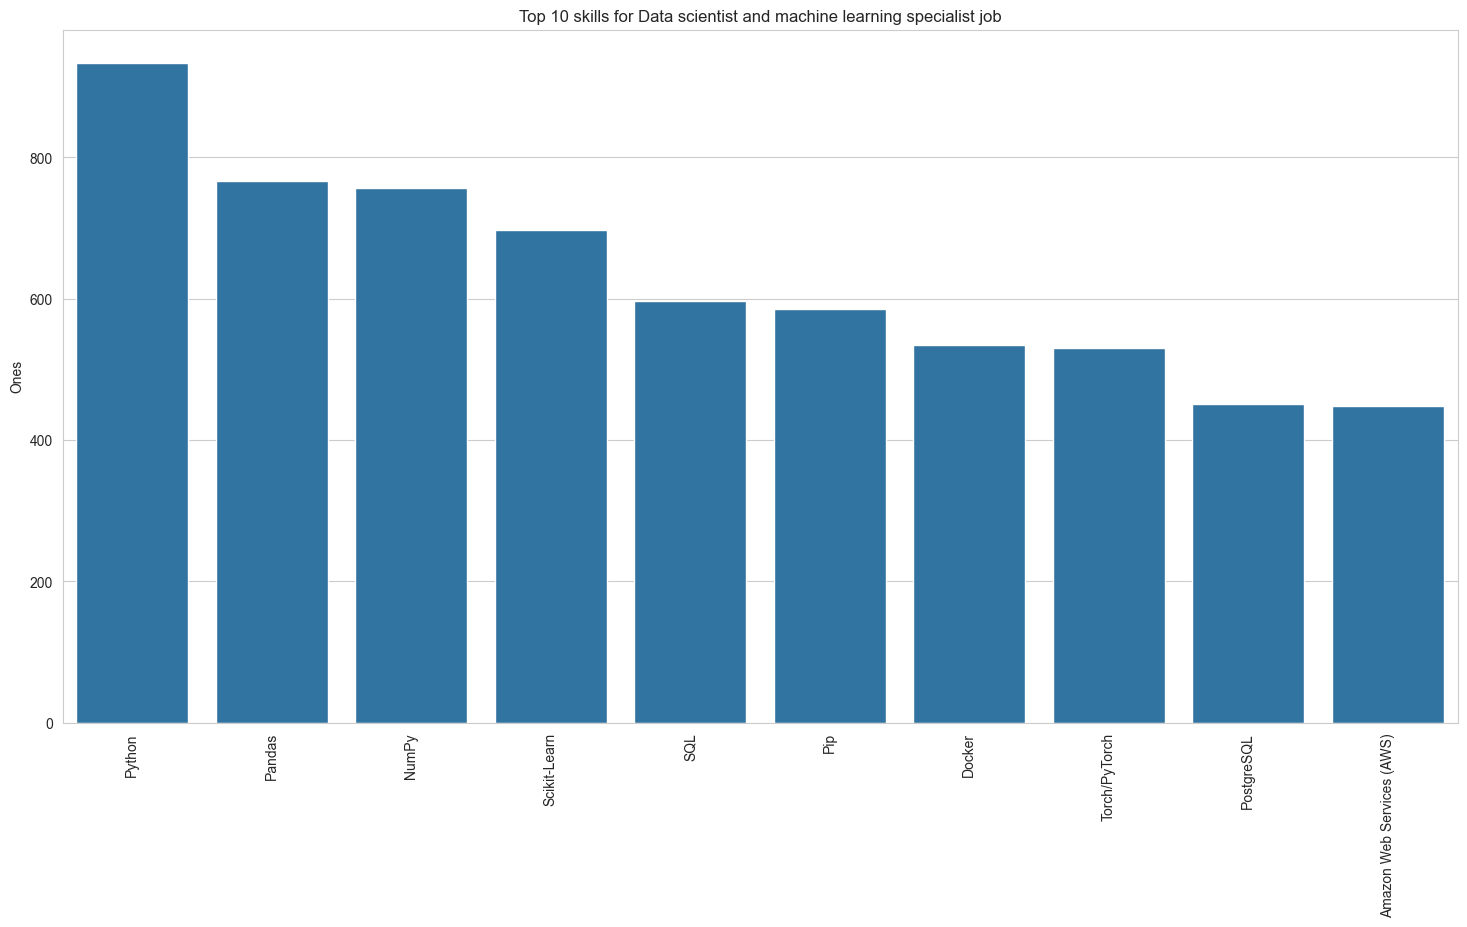

In [33]:
plt.figure(figsize=(18, 9))
sns.barplot(data=skills_freq[0:10], x=skills_freq[0:10].index.values, y=skills_freq[0:10]['Ones'])
plt.xticks(rotation=90)
plt.title("Top 10 skills for Data scientist and machine learning specialist job")
plt.show()

## Marketing or sales specialist

In [34]:
marketing_df = encoded_df[encoded_df['Marketing or sales professional'] == 1]
marketing_df

,Ada,Apex,Assembly,Bash/Shell (all shells),C,C#,C++,Clojure,Cobol,Crystal,...,Marketing or sales professional,Other (please specify):,Product manager,Project manager,Research & Development role,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",Student,System administrator
502,0,0,0,0,0,1,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1053,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3987,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4856,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60538,0,0,0,1,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60597,0,0,0,0,0,0,1,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61884,0,0,0,0,0,0,1,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62213,0,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
skills_freq = marketing_df[feats_columns].apply(lambda x: x.value_counts()).T
skills_freq.columns = ['Zeros', 'Ones']
skills_freq

,Zeros,Ones
Ada,90.0,6.0
Apex,93.0,3.0
Assembly,91.0,5.0
Bash/Shell (all shells),79.0,17.0
C,85.0,11.0
...,...,...
Vite,88.0,8.0
Webpack,85.0,11.0
Yarn,89.0,7.0
npm,67.0,29.0


In [36]:
skills_freq = skills_freq.sort_values(by='Ones', ascending=False)
skills_freq

,Zeros,Ones
HTML/CSS,32.0,64.0
JavaScript,38.0,58.0
SQL,53.0,43.0
Python,59.0,37.0
MySQL,66.0,30.0
...,...,...
Neo4J,96.0,NaN
Presto,96.0,NaN
RavenDB,96.0,NaN
Solr,96.0,NaN


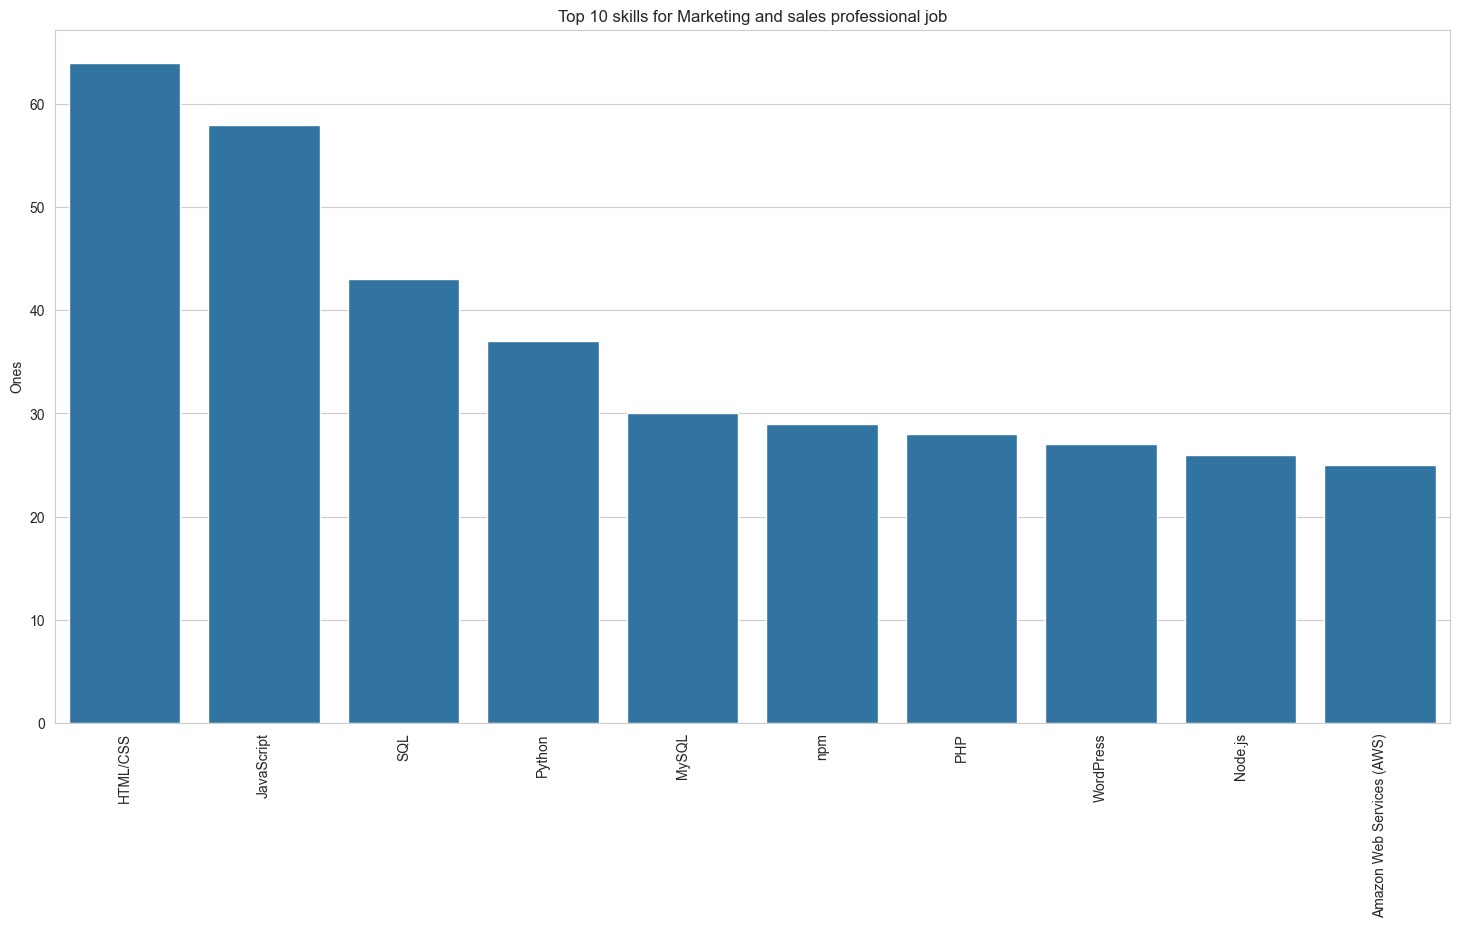

In [37]:
plt.figure(figsize=(18, 9))
sns.barplot(data=skills_freq[0:10], x=skills_freq[0:10].index.values, y=skills_freq[0:10]['Ones'])
plt.xticks(rotation=90)
plt.title("Top 10 skills for Marketing and sales professional job")
plt.show()

In [38]:
skills_freq['Ones']

HTML/CSS      64.0
JavaScript    58.0
SQL           43.0
Python        37.0
MySQL         30.0
              ... 
Neo4J          NaN
Presto         NaN
RavenDB        NaN
Solr           NaN
TiDB           NaN
Name: Ones, Length: 236, dtype: float64

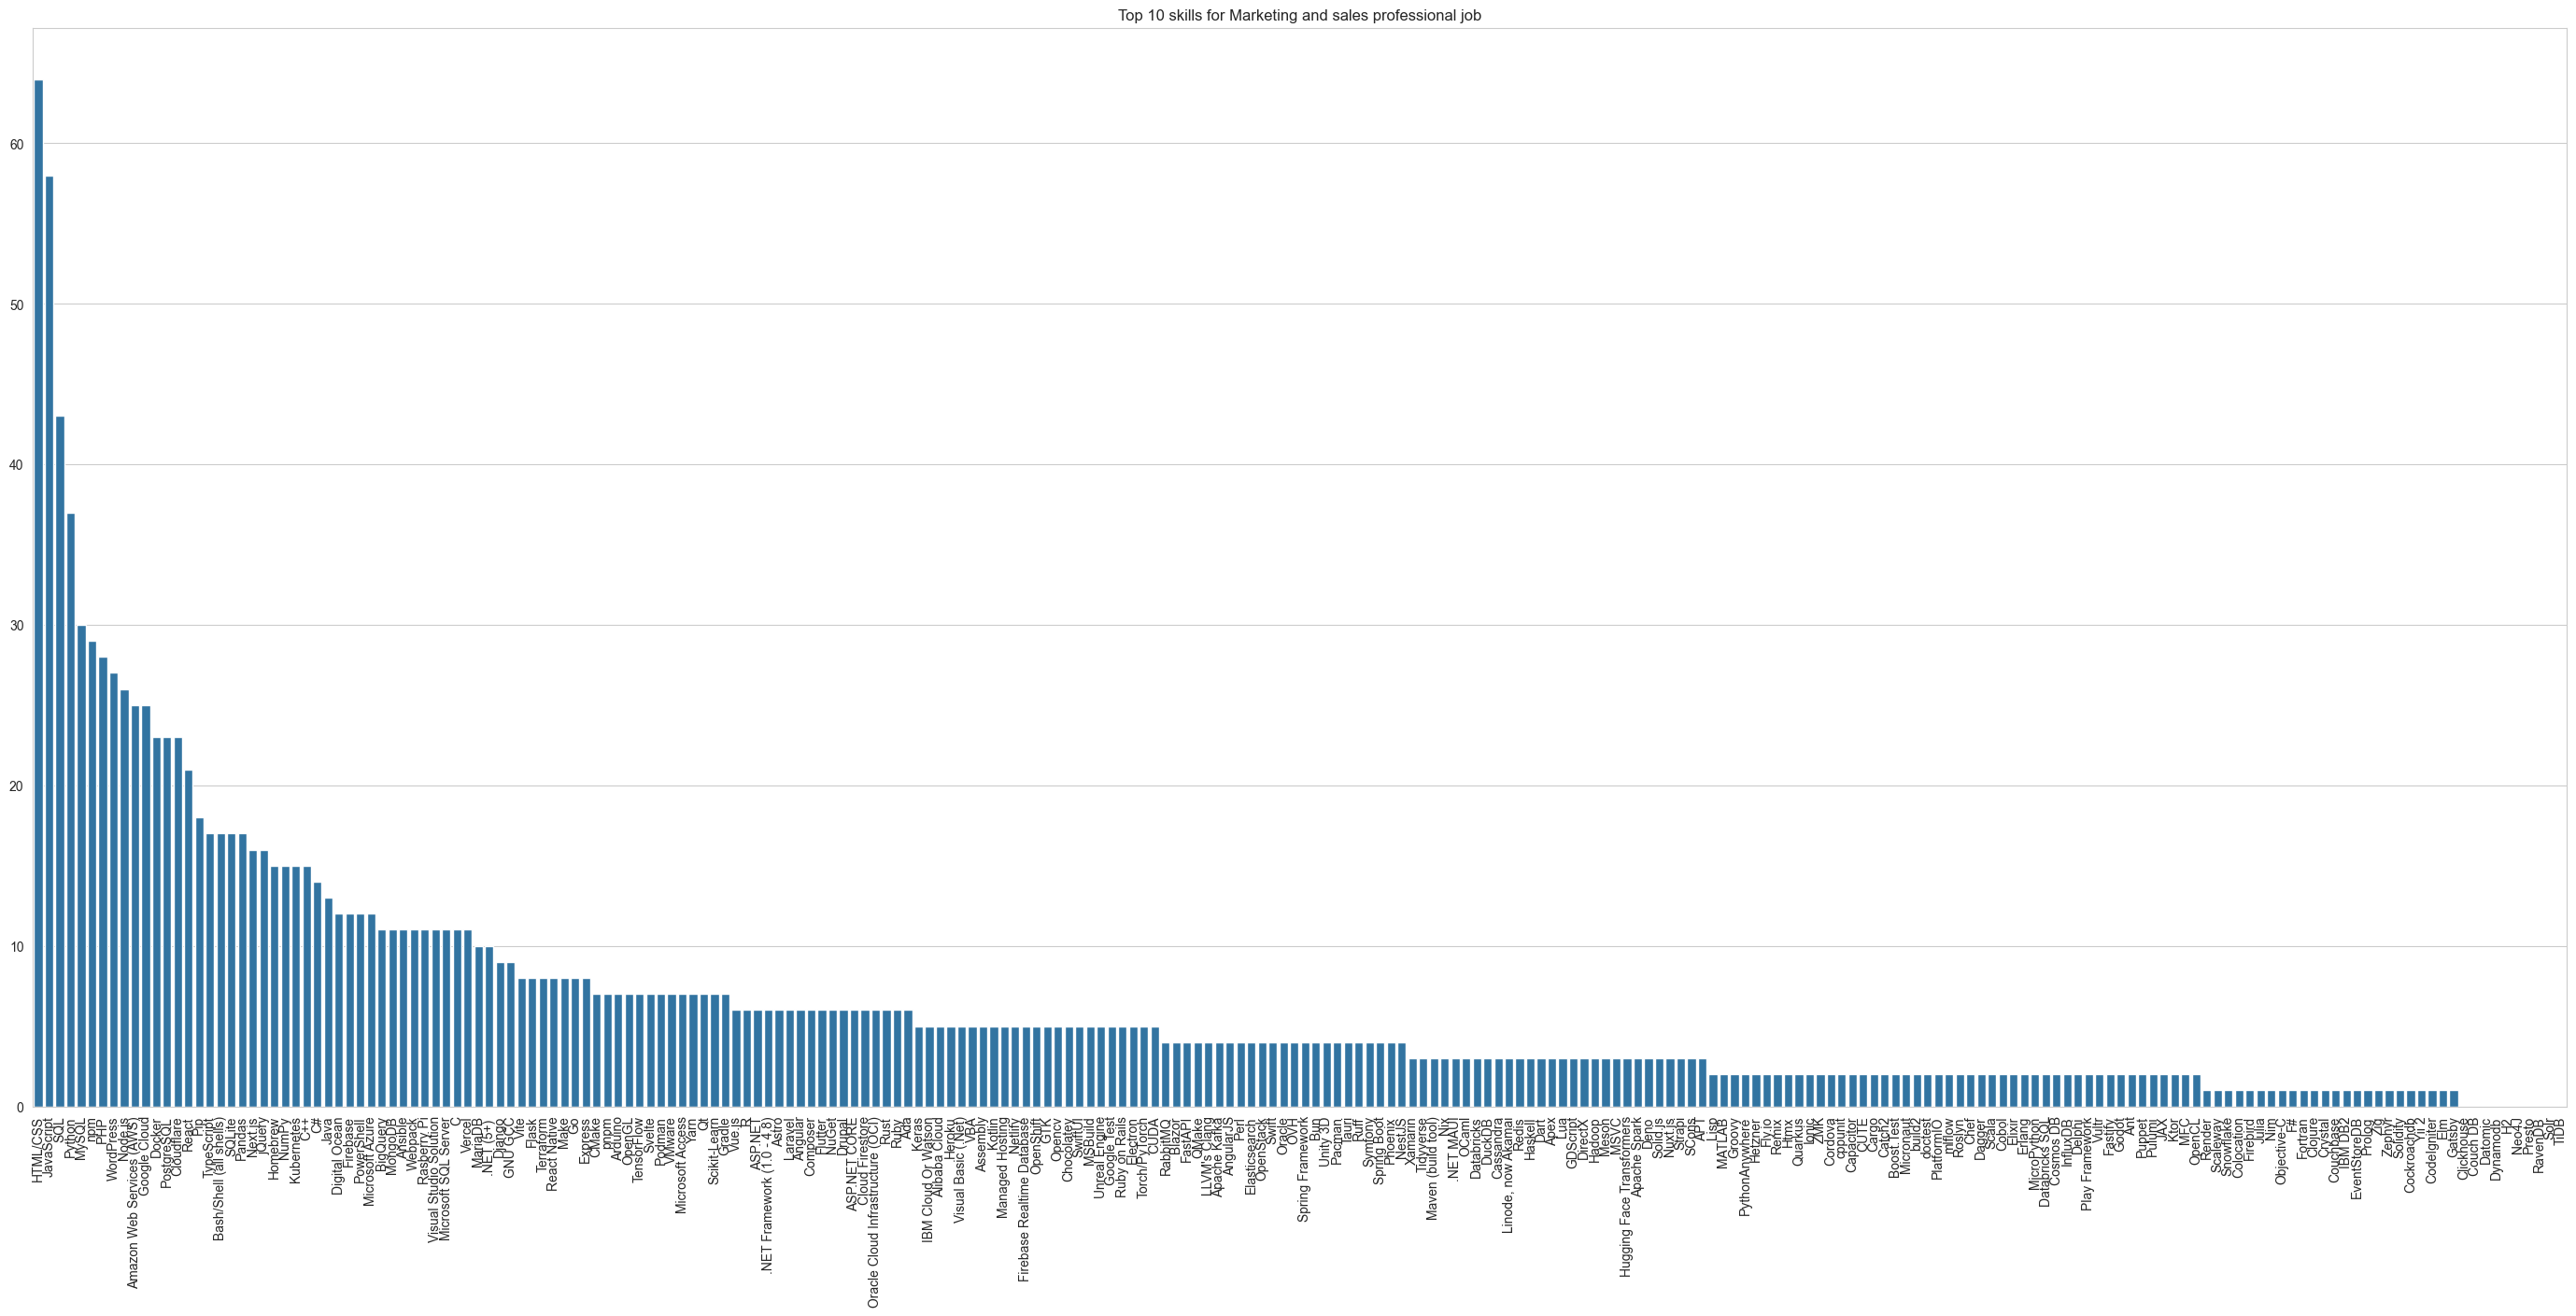

In [39]:
plt.figure(figsize=(35,15))
sns.barplot(data=skills_freq, x=skills_freq.index.values, y=skills_freq['Ones'].values)
plt.xticks(rotation=90)
plt.title("Top 10 skills for Marketing and sales professional job")
plt.show()

## Designer

In [40]:
designer_df = encoded_df[encoded_df['Designer'] == 1]
designer_df

,Ada,Apex,Assembly,Bash/Shell (all shells),C,C#,C++,Clojure,Cobol,Crystal,...,Marketing or sales professional,Other (please specify):,Product manager,Project manager,Research & Development role,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",Student,System administrator
75,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
621,0,0,0,1,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1026,0,0,1,0,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62939,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62999,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63910,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64226,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
job_freq = designer_df[feats_columns].apply(lambda x: x.value_counts()).T
job_freq.columns = ['Zeros', 'Ones']
job_freq = job_freq.sort_values(by='Ones', ascending=False)
job_freq

,Zeros,Ones
HTML/CSS,70.0,112.0
JavaScript,71.0,111.0
Python,115.0,67.0
MySQL,122.0,60.0
npm,122.0,60.0
...,...,...
TiDB,182.0,NaN
Scaleway,182.0,NaN
mlflow,182.0,NaN
Pulumi,182.0,NaN


# Create Jobs & Skills Heatmap